In [ ]:
import warnings
warnings.filterwarnings(action='ignore')
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import h2o
from h2o.estimators.gbm import H2OGradientBoostingEstimator
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor, Pool
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner
h2o.init()

# Data Cleaning

### Feature Selection

In [47]:
'''Previewing the data'''
df = pd.read_csv("cattle_data_train.csv")
pd.set_option('display.max_columns', 40)
df.head()

,Cattle_ID,Breed,Climate_Zone,Management_System,Age_Months,Weight_kg,Parity,Lactation_Stage,Days_in_Milk,Feed_Type,Feed_Quantity_kg,Feeding_Frequency,Water_Intake_L,Walking_Distance_km,Grazing_Duration_hrs,Rumination_Time_hrs,Resting_Hours,Ambient_Temperature_C,Humidity_percent,Housing_Score,FMD_Vaccine,Brucellosis_Vaccine,HS_Vaccine,BQ_Vaccine,Anthrax_Vaccine,IBR_Vaccine,BVD_Vaccine,Rabies_Vaccine,Previous_Week_Avg_Yield,Body_Condition_Score,Milking_Interval_hrs,Date,Farm_ID,Feed_Quantity_lb,Mastitis,Milk_Yield_L
0,CATTLE_133713,Holstein,Tropical,Intensive,114,544.8,4,Mid,62,Concentrates,16.363455,2,71.101024,4.77,7.8,-2.269369,12.3,28.706090,70.6,0.871430,0,1,1,0,0,1,0,1,6.31,3.0,12,2024-01-15,FARM_0301,36.8235,1,12.192634
1,CATTLE_027003,Holstein,Arid,Mixed,136,298.9,4,Mid,213,Crop_Residues,NaN,4,55.697328,5.99,7.4,8.973851,11.4,28.599741,57.5,0.825488,1,1,0,1,0,0,0,0,17.16,4.0,12,2023-10-31,FARM_0219,NaN,0,14.717031
2,CATTLE_122459,Holstein,Tropical,Semi_Intensive,64,336.6,4,Late,16,Hay,7.198607,2,65.576827,3.45,8.8,-4.590550,8.6,12.520386,51.2,0.904957,0,0,1,1,0,1,1,0,4.07,3.5,12,2024-05-20,FARM_0802,16.0965,0,14.006142
3,CATTLE_213419,Jersey,Mediterranean,Intensive,58,370.5,1,Early,339,Crop_Residues,18.694344,2,71.238287,5.95,6.5,1.792698,10.1,40.510261,57.9,0.324955,1,0,1,0,1,0,0,0,10.23,3.0,24,2024-07-22,FARM_0034,40.7925,0,24.324325
4,CATTLE_106260,Guernsey,Subtropical,Intensive,84,641.5,6,Early,125,Mixed_Feed,14.779198,4,46.979548,5.39,6.4,12.621422,9.3,-7.711288,73.2,0.871019,0,1,1,1,1,0,1,1,20.68,3.0,12,2023-01-03,FARM_0695,33.7365,1,12.023074


In [6]:
'''210,000 records, 36 features'''
display(df.shape)
display(df.columns)

(210000, 36)

Index(['Cattle_ID', 'Breed', 'Climate_Zone', 'Management_System', 'Age_Months',
       'Weight_kg', 'Parity', 'Lactation_Stage', 'Days_in_Milk', 'Feed_Type',
       'Feed_Quantity_kg', 'Feeding_Frequency', 'Water_Intake_L',
       'Walking_Distance_km', 'Grazing_Duration_hrs', 'Rumination_Time_hrs',
       'Resting_Hours', 'Ambient_Temperature_C', 'Humidity_percent',
       'Housing_Score', 'FMD_Vaccine', 'Brucellosis_Vaccine', 'HS_Vaccine',
       'BQ_Vaccine', 'Anthrax_Vaccine', 'IBR_Vaccine', 'BVD_Vaccine',
       'Rabies_Vaccine', 'Previous_Week_Avg_Yield', 'Body_Condition_Score',
       'Milking_Interval_hrs', 'Date', 'Farm_ID', 'Feed_Quantity_lb',
       'Mastitis', 'Milk_Yield_L'],
      dtype='object')

In [7]:
'''No unusual types. 8 categorical features, 28 numerical features'''
df.dtypes

Cattle_ID                   object
Breed                       object
Climate_Zone                object
Management_System           object
Age_Months                   int64
Weight_kg                  float64
Parity                       int64
Lactation_Stage             object
Days_in_Milk                 int64
Feed_Type                   object
Feed_Quantity_kg           float64
Feeding_Frequency            int64
Water_Intake_L             float64
Walking_Distance_km        float64
Grazing_Duration_hrs       float64
Rumination_Time_hrs        float64
Resting_Hours              float64
Ambient_Temperature_C      float64
Humidity_percent           float64
Housing_Score              float64
FMD_Vaccine                  int64
Brucellosis_Vaccine          int64
HS_Vaccine                   int64
BQ_Vaccine                   int64
Anthrax_Vaccine              int64
IBR_Vaccine                  int64
BVD_Vaccine                  int64
Rabies_Vaccine               int64
Previous_Week_Avg_Yi

In [ ]:
'''Describe is great. We investigated all max values to see if any seemed absurd with respect to their
feature range, and found rumination suspicious. We did the same with min values, and found suspicious
negatives and zeros for rumination and milk yield, which we explore more in future cells. 
Count told us which features had missing values, which included Feed_Quantity_kg, Feed_Quantity_lb and 
Housing_Score.'''

df.describe()

,Age_Months,Weight_kg,Parity,Days_in_Milk,Feed_Quantity_kg,Feeding_Frequency,Water_Intake_L,Walking_Distance_km,Grazing_Duration_hrs,Rumination_Time_hrs,Resting_Hours,Ambient_Temperature_C,Humidity_percent,Housing_Score,FMD_Vaccine,Brucellosis_Vaccine,HS_Vaccine,BQ_Vaccine,Anthrax_Vaccine,IBR_Vaccine,BVD_Vaccine,Rabies_Vaccine,Previous_Week_Avg_Yield,Body_Condition_Score,Milking_Interval_hrs,Feed_Quantity_lb,Mastitis,Milk_Yield_L
count,210000.000000,210000.000000,210000.000000,210000.000000,199519.000000,210000.000000,210000.000000,210000.000000,210000.000000,210000.000000,210000.000000,210000.000000,210000.000000,203721.000000,210000.000000,210000.000000,210000.000000,210000.000000,210000.000000,210000.000000,210000.000000,210000.000000,210000.000000,210000.000000,210000.000000,199519.000000,210000.000000,210000.000000
mean,83.483905,499.930430,3.500395,182.112967,12.014793,2.999119,80.036850,4.034754,6.056710,0.256557,10.067602,21.883678,59.814050,0.649080,0.599267,0.600071,0.599657,0.600700,0.600381,0.598814,0.599824,0.600824,8.747584,3.394726,12.302438,26.492720,0.099976,15.589156
std,34.648982,144.659172,1.707383,105.051486,3.969247,1.413147,14.987677,1.928529,2.867575,6.115351,2.865591,11.694866,19.489516,0.202515,0.490048,0.489885,0.489969,0.489756,0.489821,0.490140,0.489935,0.489730,5.901473,0.632831,4.298998,8.741282,0.299969,5.352079
min,24.000000,250.000000,1.000000,1.000000,2.370284,1.000000,14.207737,0.500000,1.000000,-8.808053,5.000000,-11.863353,10.000000,0.269460,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,6.000000,6.615000,0.000000,-5.700324
25%,54.000000,374.200000,2.000000,91.000000,9.283265,2.000000,69.919162,2.650000,4.000000,-4.383302,8.000000,13.882059,46.400000,0.473948,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.270000,3.000000,12.000000,20.506500,0.000000,11.822207
50%,83.000000,500.200000,3.000000,182.000000,12.002254,3.000000,80.016973,4.000000,6.000000,-0.818631,10.000000,22.003491,60.000000,0.648184,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.710000,3.500000,12.000000,26.460000,0.000000,15.145871
75%,114.000000,625.700000,5.000000,273.000000,14.708920,4.000000,90.119812,5.350000,8.000000,4.051704,12.000000,30.084183,73.500000,0.824627,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,12.410000,4.000000,12.000000,32.413500,0.000000,18.884708
max,143.000000,750.000000,6.000000,364.000000,25.454207,5.000000,149.960210,12.000000,14.000000,31.263406,18.000000,47.192325,100.000000,1.033372,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,38.670000,5.000000,24.000000,55.125000,1.000000,44.555285


In [ ]:
'''We wanted to view variable importances to determine which features to focus on first. 
Here we train the raw data with cv just to get a quick estimate of variable importance.
This will guide early EDA, research, and experiments. Using h2o's gbm due to its simplicity
and diagnostics. Adjusting hyperparameters until variable importances stabilize. '''

# Convert to H2OFrame
hf = h2o.H2OFrame(df)
y = "Milk_Yield_L"
x = [c for c in hf.columns if c != y]

gbm = H2OGradientBoostingEstimator(
	ntrees=300,
	max_depth=5,
	learn_rate=0.1,
    seed=36,
    nfolds=5,
    fold_assignment="Modulo",
	score_tree_interval=300
)

gbm.train(x=x, y=y, training_frame=hf)
varimp = gbm.varimp(use_pandas=True)
varimp

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


,variable,relative_importance,scaled_importance,percentage
0,Farm_ID,8.085030e+06,1.000000,0.384731
1,Age_Months,3.576766e+06,0.442394,0.170203
2,Weight_kg,2.898508e+06,0.358503,0.137927
3,Parity,1.771818e+06,0.219148,0.084313
4,Date,9.768691e+05,0.120824,0.046485
5,Feed_Quantity_lb,8.950978e+05,0.110711,0.042594
6,Feed_Quantity_kg,6.810401e+05,0.084235,0.032408
7,Water_Intake_L,5.010182e+05,0.061969,0.023841
8,Mastitis,4.717995e+05,0.058355,0.022451
9,Days_in_Milk,2.814358e+05,0.034809,0.013392


In [51]:
'''Base model and data for upcoming cleaning tests'''

basedf = df.copy()
basehf = h2o.H2OFrame(df)
basey = "Milk_Yield_L"
basex = [c for c in hf.columns if c != y]
basegbm = H2OGradientBoostingEstimator(
	ntrees=300,
    seed=36,
    nfolds=5,
    fold_assignment="Modulo"
)
basegbm.train(x=basex, y=basey, training_frame=basehf)
''''''

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


''

In [52]:
'''Variable importance assessment shows vaccines at the bottom. Studies indicate vaccines have
variable impact on milk yield. Most of the impact was usually the weeks immediately after
the vaccine had been received, but we don't have that stat here. The vaccines in our dataset
are also represented in binary, and with so many low cardinality columns they're likely
diluting each other. We're gonna try selecting vaccines to see how RMSE is impacted.

Feed_Quantity_kg is redundant and less precise and varimp to the lb version. Try dropping.

Don't need Cattle_ID'''

df2 = basedf[[
	   	'Cattle_ID',
	   	'Breed', 'Climate_Zone', 'Management_System', 'Age_Months',
       	'Weight_kg', 'Parity', 'Lactation_Stage', 'Days_in_Milk', 'Feed_Type',
       	#'Feed_Quantity_kg', 
	   	'Feeding_Frequency', 'Water_Intake_L',
       	'Walking_Distance_km', 'Grazing_Duration_hrs', 'Rumination_Time_hrs',
       	'Resting_Hours', 'Ambient_Temperature_C', 'Humidity_percent',
       	'Housing_Score', 
	   	'FMD_Vaccine',
		'Brucellosis_Vaccine',
		'HS_Vaccine',
       	'BQ_Vaccine',
		'Anthrax_Vaccine',
		'IBR_Vaccine',
		'BVD_Vaccine',
       	'Rabies_Vaccine',
	   	'Previous_Week_Avg_Yield', 'Body_Condition_Score',
       	'Milking_Interval_hrs', 'Date', 'Farm_ID', 'Feed_Quantity_lb',
       	'Mastitis', 'Milk_Yield_L'
		]].copy()

In [53]:
''' Training with various feature selections based on variable importance. Looking for negative value
outputs indicating our new model's rmse is lower than the previous model'''

hf2 = h2o.H2OFrame(df2)
y = "Milk_Yield_L"
x = [c for c in hf2.columns if c != y]

gbm2 = H2OGradientBoostingEstimator(
	ntrees=300,
    seed=36,
    nfolds=5,
    fold_assignment="Modulo"
)

gbm2.train(x=x, y=y, training_frame=hf2)
print("Base RMSE:", basegbm.rmse(xval=True))
print("Mod. RMSE:", gbm2.rmse(xval=True))
print("Δ RMSE:   ",gbm2.rmse(xval=True) - basegbm.rmse(xval=True))

'''Nothing improved RMSE. Even dropping Cattle_ID, so we're thinking h2ogbm was
able to detect and ignore it.''';

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Base RMSE: 4.403519155842472
Mod. RMSE: 4.4056748538800035
Δ RMSE:    0.0021556980375310175


### Data Errors

negative milk yield records: (74, 36)
negative rumination records: (115627, 36)
24hr plus rumination records: (88, 36)
min rumination:  -8.80805285633959
cows at min rumination: 6669


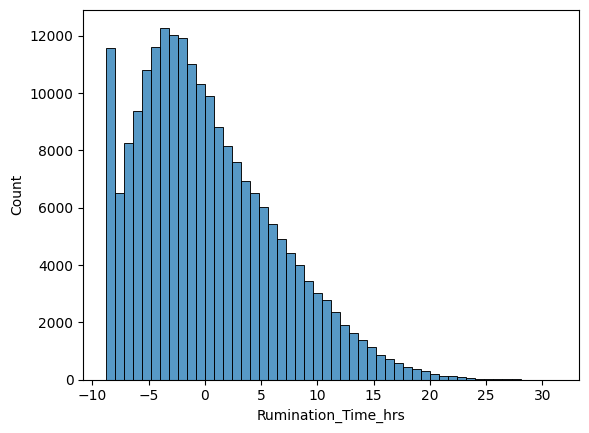

In [54]:
'''Milk yield and rumination have negative values. 74 milk yield records are negative, so we can simply remove them. 
But more than half of the records have a negative rumination, and we can't just remove those. Also, max rumination
seems abnormally high, and is a big jump from 75%. There's only 88 records that are above 24 rumination hrs. We can
cap or remove these, as its likely safe to assume rumination was intended to be per day based on the other values. '''

print("negative milk yield records:", basedf[basedf["Milk_Yield_L"] < 0].shape)
print("negative rumination records:", basedf[basedf["Rumination_Time_hrs"] < 0].shape)
basedf["Rumination_Time_hrs"].describe()
print("24hr plus rumination records:", basedf[basedf["Rumination_Time_hrs"] > 24].shape)

'''Investigating negative rumination further '''

sns.histplot(basedf["Rumination_Time_hrs"], bins=50)
min_val = basedf["Rumination_Time_hrs"].min()
count_min = (basedf["Rumination_Time_hrs"] == min_val).sum()
print("min rumination: ", min_val)
print("cows at min rumination:", count_min)
plt.show()

'''We can just shift the data by the minimum value to keep things real.
We've noted a spike at the minimum, and we can experiment with engineering an
is_low_ruminationion binary feature later.''';

In [ ]:
''' Removing milk negatives, shifting, capping & removing rumination'''

df3 = basedf[basedf["Milk_Yield_L"] >= 0].copy()
# df3["Rumination_Time_hrs"] = df3["Rumination_Time_hrs"].clip(upper=24)
df3["Rumination_Time_hrs"] = df3["Rumination_Time_hrs"] - min_val
# df3 = df3[df3["Rumination_Time_hrs"] <= 24]

In [ ]:
'''Acknowledging here that the following tests have mild leakage in them. In the previous cell, we removed
negative milk yields from the entire data set. We also shift rumination by a global minimum. These calculations
should occur independently in the training and validation sets, but we haven't set up a pipeline for that yet. 
Significant improvements can still act as guidance but we will remain cautious for now.'''

hf3 = h2o.H2OFrame(df3)
y = "Milk_Yield_L"
x = [c for c in hf3.columns if c != y]

gbm3 = H2OGradientBoostingEstimator(
    ntrees=150,
    max_depth=5,
    learn_rate=0.1,
    seed=36,
    nfolds=5,
    fold_assignment="Modulo",
	score_tree_interval=150
)

gbm3.train(x=x, y=y, training_frame=hf3)
print("Base RMSE:", basegbm.rmse(xval=True))
print("Mod. RMSE:", gbm3.rmse(xval=True))
print("Δ RMSE:   ",gbm3.rmse(xval=True) - basegbm.rmse(xval=True))

'''Shifting very slightly improved the model. Removing negative milk yields improved the model, 
as it should. However, capping & removing max ruminations hurt the model, so those outliers might
just be meaningful and worth keeping.'''

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Base RMSE: 4.404198844031265
Mod. RMSE: 4.328451714035303
Δ RMSE:    -0.07574712999596223


'Shifting very slightly improved the model. Removing negative milk yields improved the model, \nas it should. However, capping & removing max ruminations hurt the model, so those outliers might\njust be meaningful and worth keeping.'

In [159]:
'''Feed quantities are missing 10k values and housing score is missing 6k values.
Imputing feed and housing score by their farm_ID mean feed/house scores since its
the strongest feature. We can also just try a global mean.'''

df4 = basedf.copy()
feed_farm_mean = df4.groupby("Farm_ID")["Feed_Quantity_lb"].transform("mean")
df4["Feed_Quantity_lb"] = df4["Feed_Quantity_lb"].fillna(feed_farm_mean)
feed_farm_mean2 = df4.groupby("Farm_ID")["Feed_Quantity_kg"].transform("mean")
df4["Feed_Quantity_kg"] = df4["Feed_Quantity_kg"].fillna(feed_farm_mean2)
housing_farm_mean = df4.groupby("Farm_ID")["Housing_Score"].transform("mean")
df4["Housing_Score"] = df4["Housing_Score"].fillna(housing_farm_mean)
# df4["Feed_Quantity_lb"] = df4["Feed_Quantity_lb"].fillna(df4["Feed_Quantity_lb"].mean())
# df4["Feed_Quantity_kg"] = df4["Feed_Quantity_kg"].fillna(df4["Feed_Quantity_kg"].mean())
# df4["Housing_Score"]     = df4["Housing_Score"].fillna(df4["Housing_Score"].mean())

In [ ]:
'''Testing'''

hf4 = h2o.H2OFrame(df4)
y = "Milk_Yield_L"
x = [c for c in hf4.columns if c != y]

gbm4 = H2OGradientBoostingEstimator(
    ntrees=150,
    max_depth=5,
    learn_rate=0.1,
    seed=36,
    nfolds=5,
    fold_assignment="Modulo",
	score_tree_interval=150
)

gbm4.train(x=x, y=y, training_frame=hf4)
print("Base RMSE:", basegbm.rmse(xval=True))
print("Mod. RMSE:", gbm4.rmse(xval=True))
print("Δ RMSE:   ",gbm4.rmse(xval=True) - basegbm.rmse(xval=True))
'''Imputing with farm_ID means is better than global means.'''

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Base RMSE: 4.404198844031265
Mod. RMSE: 4.331473610569546
Δ RMSE:    -0.07272523346171944


'Imputing with farm_ID means is better than global means.'

In [ ]:
'''When graphing breeds in the EDA section, we discovered misspellings'''

df5 = basedf.copy()
breed_counts = df5["Breed"].value_counts().sort_values(ascending=False)
display(breed_counts)

# strip leading whitespace
df5["Breed"] = df5["Breed"].str.strip()

# manually adjust other 2 misspellings
df5["Breed"] = df5["Breed"].replace({
    "Holstien": "Holstein",
    "Brown Swiss": "Brown Swiss",
})
display(df5["Breed"].value_counts())

'''Not testing, needs to be fixed''';

Breed
Holstein        104775
Jersey           42183
Guernsey         31672
Brown Swiss      31155
Holstien           112
 Brown Swiss        57
Brown Swiss         46
Name: count, dtype: int64

Breed
Holstein       104887
Jersey          42183
Guernsey        31672
Brown Swiss     31258
Name: count, dtype: int64

In [ ]:
'''Let's check for duplicates'''

df6 = basedf.copy()

# count of duplicate cattle ids
dupe_ids = df6["Cattle_ID"][df6["Cattle_ID"].duplicated()].unique()
print(len(dupe_ids))

# If duplicate cattle ids have different breeds, records are unreliable so drop
breed_counts = df6.groupby("Cattle_ID")["Breed"].transform("nunique")
df6 = df6[breed_counts == 1].copy()

# count of duplicate cattle ids post clean
dupe_ids = df6["Cattle_ID"][df6["Cattle_ID"].duplicated()].unique()
print(len(dupe_ids))

# remaining paired duplicate ids
remaining_dupes = df6["Cattle_ID"][df6["Cattle_ID"].duplicated()].unique()
dupe_rows = df6[df6["Cattle_ID"].isin(remaining_dupes)]
dupe_rows = dupe_rows.sort_values(["Cattle_ID", "Date"])

# display(dupe_rows)

''' Okay after just manually inspecting the remaining 14 duplicates by hand, these features stood out
    Feed_Quantity_kg - extremely miniscule variation
	Water_Intake_L - pretty substantial variation
	Ambient_Temperature_C - extremely miniscule variation
	Housing_Score - miniscule variation
	Milk_Yield_L - significant enough
 '''

'''So 14 dupe records with tiny variations apart from water leading to noticable changes in milk yield, so lets
just remove them. When I add this to the pipe, just one liner drop all 34 dupliactes or so.'''

df6 = df6[~df6["Cattle_ID"].duplicated(keep=False)].copy()
dupe_ids = df6["Cattle_ID"][df6["Cattle_ID"].duplicated()].unique()
print(len(dupe_ids))

df6.shape
'''Not testing, needs to be fixed.''';

34
14
0


### X-Feature Inconsistencies

In [57]:
'''We introduced this section after building our cv pipeline, which was used to test
these inconsistencies. Inspiration for comparing DIM and lactation stage came from
the lactation curve. DIM should correspond to lactation stage.
'''

df7 = basedf.copy()
df7.describe()

def expected_stage(dim):
    if pd.isna(dim):
        return "Unknown"
    if dim < 90:
        return "Early"
    elif dim < 180:
        return "Mid"
    else:
        return "Late"

df7["Expected_Stage"] = df7["Days_in_Milk"].apply(expected_stage)

# Compare provided vs expected
df7["Stage_Mismatch"] = (df7["Lactation_Stage"] != df7["Expected_Stage"])

# Count mismatches
mismatch_counts = df7["Stage_Mismatch"].value_counts()
print(mismatch_counts)

# Show examples of mismatches
print(df7[df7["Stage_Mismatch"] == True][[
    "Cattle_ID","Days_in_Milk","Lactation_Stage","Expected_Stage"
]].head(20))

'''
We tried:
Dropping lactation stage -> worse
Dropping DIM             -> worse
Binary mismatch          -> neutral
Mismatch correction      -> worse

We never really fully understood this. I guess we're assuming that DIM
should correspond to lactation stage, and yet there's a concerning amount
of records that don't. Our assumption may just be wrong.
''';

Stage_Mismatch
True     141777
False     68223
Name: count, dtype: int64
        Cattle_ID  Days_in_Milk Lactation_Stage Expected_Stage
0   CATTLE_133713            62             Mid          Early
1   CATTLE_027003           213             Mid           Late
2   CATTLE_122459            16            Late          Early
3   CATTLE_213419           339           Early           Late
4   CATTLE_106260           125           Early            Mid
5   CATTLE_090774           174            Late            Mid
7   CATTLE_081978            53             Mid          Early
9   CATTLE_021443           352             Mid           Late
11  CATTLE_080115            82             Mid          Early
12  CATTLE_105031             4             Mid          Early
13  CATTLE_016766           204             Mid           Late
14  CATTLE_077148           321             Mid           Late
15  CATTLE_034861           343           Early           Late
16  CATTLE_239967           109           Ear

In [58]:
''' Are feed lb and kg proportional? '''

df["Feed_Ratio_lb_per_kg"] = df["Feed_Quantity_lb"] / (df["Feed_Quantity_kg"] * 2.20462)
df["Feed_Ratio_lb_per_kg"].describe()

''' Dropping feed in kg improved performance by like .00001. lb worsened performance.
keep kg dropped. ''';

# Data Exploration

### Variably Important Features

Farm_ID

Unique farms in test: 0
count    1000.000000
mean      210.000000
std        14.742841
min       160.000000
25%       200.000000
50%       210.000000
75%       220.000000
max       252.000000
Name: count, dtype: float64


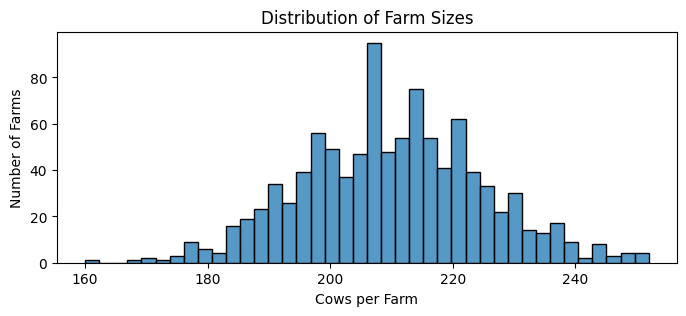

count    1000.000000
mean       15.589178
std         0.362196
min        14.508578
25%        15.355781
50%        15.585569
75%        15.847463
max        16.684882
Name: mean, dtype: float64
count    1000.000000
mean        5.345073
std         0.293981
min         4.468683
25%         5.132416
50%         5.337973
75%         5.542709
max         6.450633
Name: std, dtype: float64


In [59]:
''' Exploring Farm_ID, highest variable importance feature.'''
trainData = pd.read_csv("cattle_data_train.csv")

# Are there farms in testData but not in trainData??
print("Unique farms in test:", len(set(pd.read_csv("cattle_data_test.csv")["Farm_ID"]) - set(trainData["Farm_ID"])))

# Are there outlier farms with too little or too many cows?
farm_sizes = trainData["Farm_ID"].value_counts()
print(farm_sizes.describe())
plt.figure(figsize=(8,3))
sns.histplot(farm_sizes, bins=40, kde=False)
plt.title("Distribution of Farm Sizes")
plt.xlabel("Cows per Farm")
plt.ylabel("Number of Farms")
plt.show()

# How much does milk yield vary between farms?
farm_stats = trainData.groupby("Farm_ID")["Milk_Yield_L"].agg(["mean","std","count"])
print(farm_stats["mean"].describe())

# How much does milk yield vary within the farm (std)?
print(farm_stats["std"].describe())

'''
All farms in testData are in trainData, so our farm_ID won't break 
generalization. The min and max # of cows in a farm is 160, 252 and nicely 
distributed. Farms have different milk yield means, which is unsurprising
because farms have different standards and hidden features. The variation of
milk yield within a farm is significant, with a std of about 5.3. Farm_ID mean
gives the model a strong baseline, but std shows there's still within-farm
variation to engineer out with the remaining features.

I think we can target-encode farm_ID. Basically gives the model an exact quality
estimate describing the farm so it doesn't have to work it out itself. This could
be just mean, but maybe std as well and turn it into some target-encode formula?
On top of this, we can aggregate farm_mean_yield, or farm_std_yield, but this is 
not a priority yet. These are target-derived transformations, so I'll try them last.
''';

Age_Months

count    210000.000000
mean         83.483905
std          34.648982
min          24.000000
25%          54.000000
50%          83.000000
75%         114.000000
max         143.000000
Name: Age_Months, dtype: float64


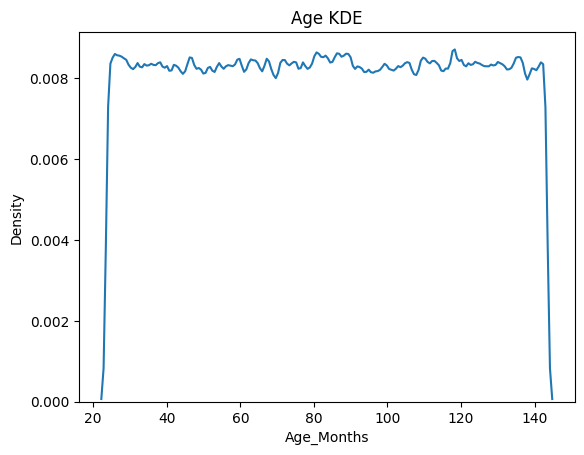

In [60]:

# Is there a bias in the distribution of age?
print(trainData["Age_Months"].describe())
sns.kdeplot(trainData["Age_Months"], bw_adjust=0.2)
plt.title("Age KDE")
plt.show()

'''
Age is clean, stable, well-distributed. Probably best to just focus on domain knowledge.
''';

Weight_kg

count    210000.000000
mean        499.930430
std         144.659172
min         250.000000
25%         374.200000
50%         500.200000
75%         625.700000
max         750.000000
Name: Weight_kg, dtype: float64


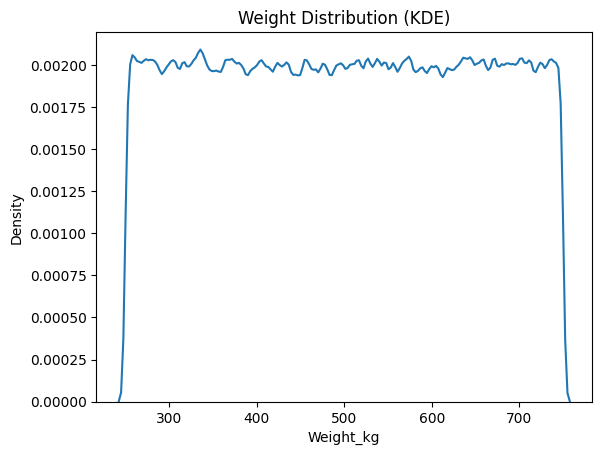

In [61]:
# Distribution of weight?
print(trainData["Weight_kg"].describe())
sns.kdeplot(trainData["Weight_kg"], bw_adjust=0.2)
plt.title("Weight Distribution (KDE)")
plt.show()


'''
Weight is clean, stable, well-distributed. Probably best to just focus on domain knowledge.
''';

Parity

count    210000.000000
mean          3.500395
std           1.707383
min           1.000000
25%           2.000000
50%           3.000000
75%           5.000000
max           6.000000
Name: Parity, dtype: float64
Parity
1    34920
2    35008
3    35101
4    35123
5    34736
6    35112
Name: count, dtype: int64


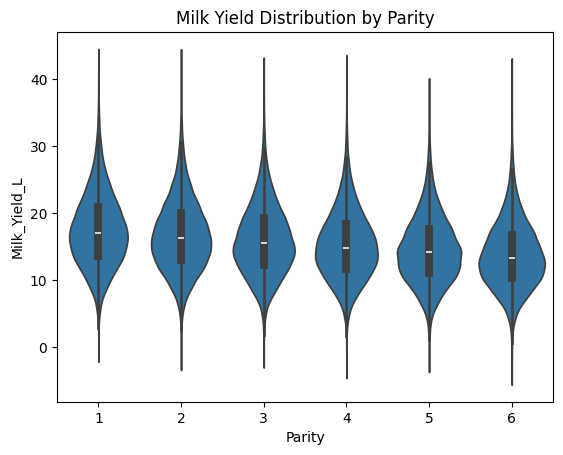

In [62]:
# Distribution of parity?
print(trainData["Parity"].describe())
print(trainData["Parity"].value_counts().sort_index())
sns.violinplot(x="Parity", y="Milk_Yield_L", data=trainData, cut=0)
plt.title("Milk Yield Distribution by Parity")
plt.show()


'''
Milk yield appears to decline with parity. Other than that it's stable and well-distributed.
''';

Feed_Quantity_lb

count    199519.000000
mean         26.492720
std           8.741282
min           6.615000
25%          20.506500
50%          26.460000
75%          32.413500
max          55.125000
Name: Feed_Quantity_lb, dtype: float64


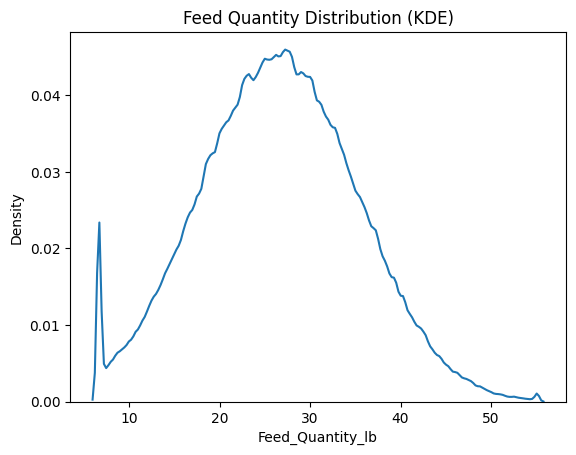


Low-feed milk yield avg/std/count: 12.862384845055084 4.6557102335768565 3304
Normal-feed milk yield avg/std/count: 15.632742555642423 5.351214596922676 206696


In [64]:
# Is there bias in the distribution of feed?
print(trainData["Feed_Quantity_lb"].describe())
sns.kdeplot(trainData["Feed_Quantity_lb"], bw_adjust=0.3)
plt.title("Feed Quantity Distribution (KDE)")
plt.show()

'''
Finally, an abnormality. There's a feed level at the minimum that's extremely dense.
Probably like a minimum allowed feed or some statistically efficient feed for farms?
Also, the count is 199519 instead of 210000, meaning there are nan values we need to
fill in. Will need to clean that somehow.
'''

# Is this spike an error or valuable information?
min_feed = trainData["Feed_Quantity_lb"].min()
low_band = trainData["Feed_Quantity_lb"].between(min_feed, min_feed + 1)
low_count = low_band.sum()
normal_count = (~low_band).sum()

# Milk yield comparison
low_mean = trainData.loc[low_band, "Milk_Yield_L"].mean()
low_std  = trainData.loc[low_band, "Milk_Yield_L"].std()
norm_mean = trainData.loc[~low_band, "Milk_Yield_L"].mean()
norm_std  = trainData.loc[~low_band, "Milk_Yield_L"].std()
print("\nLow-feed milk yield avg/std/count:", low_mean, low_std, low_count)
print("Normal-feed milk yield avg/std/count:", norm_mean, norm_std, normal_count)

'''
This spike represents just 1.57% of cows. These cows appear to have significantly
lower milk yield than others. An Is_Low_Feed feature might be valuable.
''';

### Target vs Key Features

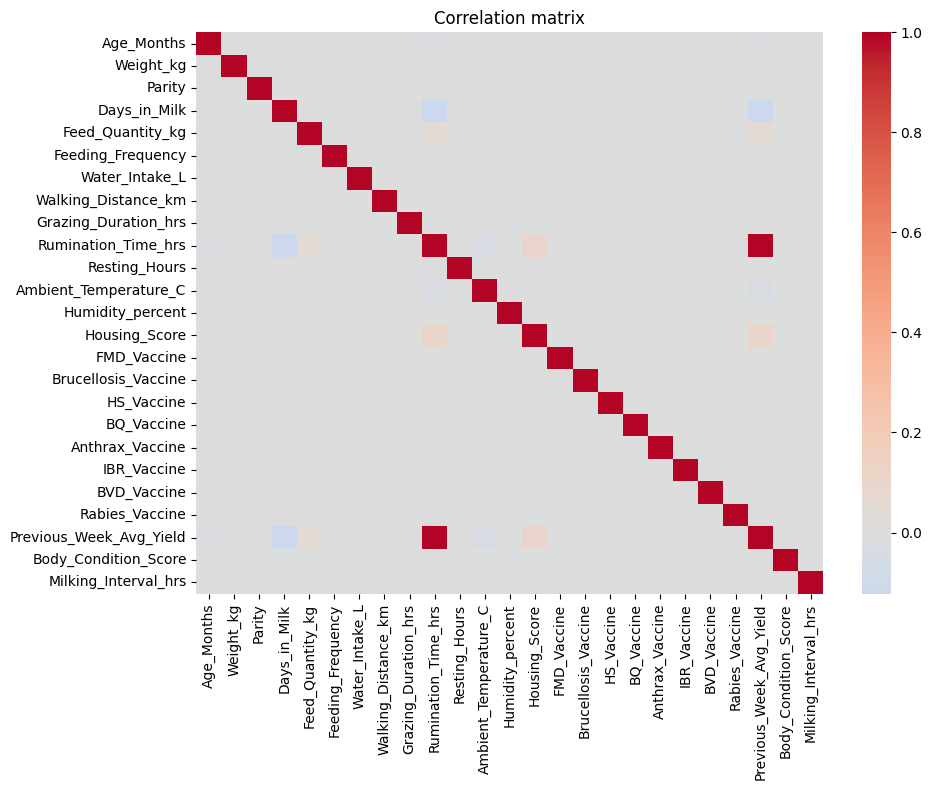

In [28]:
'''Numeric correlation heatmap'''
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_for_corr = numeric_cols[:25]
if len(num_for_corr) > 1:
    plt.figure(figsize=(10, 8))
    corr = df[num_for_corr].corr()
    sns.heatmap(corr, annot=False, cmap='coolwarm', center=0)
    plt.title('Correlation matrix')
    plt.tight_layout()

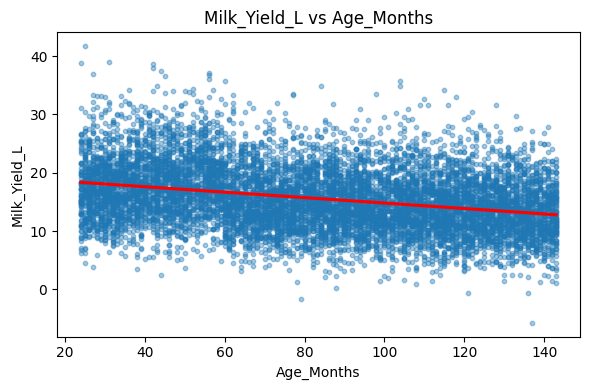

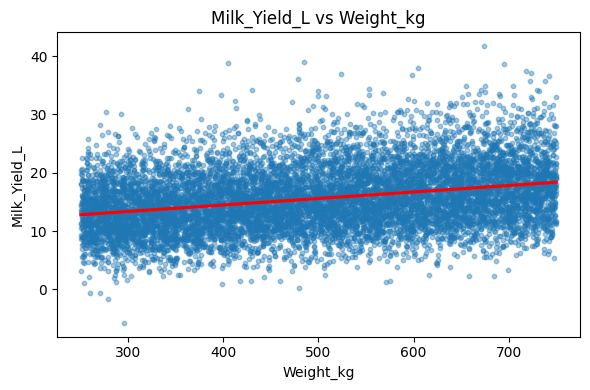

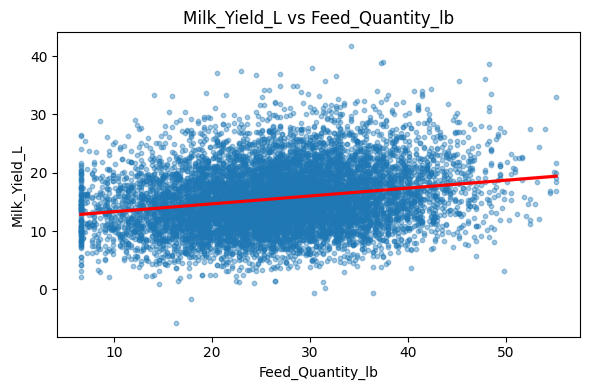

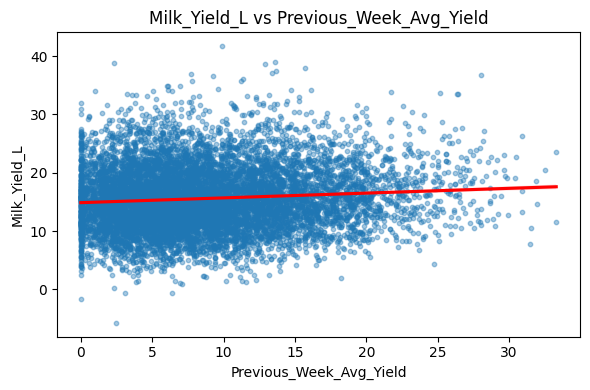

In [25]:
'''Target vs key numeric predictors'''

df = trainData.copy()

pairs = ['Age_Months', 'Weight_kg', 'Feed_Quantity_lb', 'Previous_Week_Avg_Yield']
for col in pairs:
    if col in df.columns and 'Milk_Yield_L' in df.columns:
        plt.figure(figsize=(6,4))
        sns.regplot(x=col, y='Milk_Yield_L', data=df.sample(n=min(10000, len(df)), random_state=0),
                    scatter_kws={'s':10, 'alpha':0.4}, line_kws={'color':'red'})
        plt.title(f'Milk_Yield_L vs {col}')
        plt.tight_layout()

### Categoricals

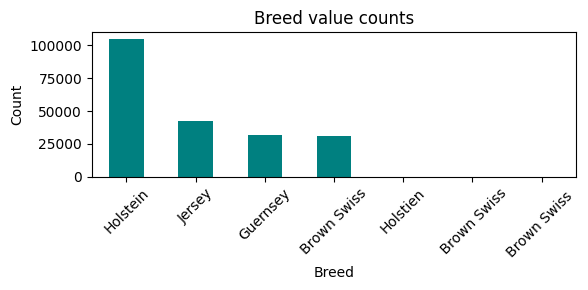

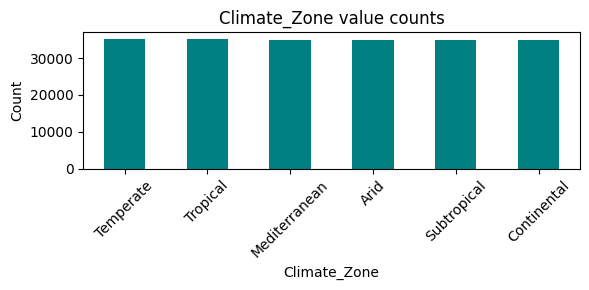

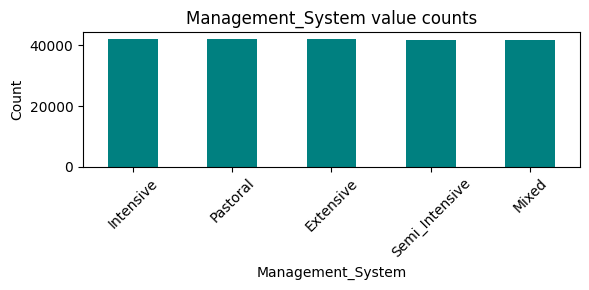

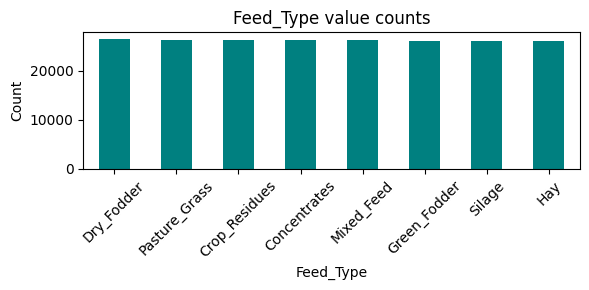

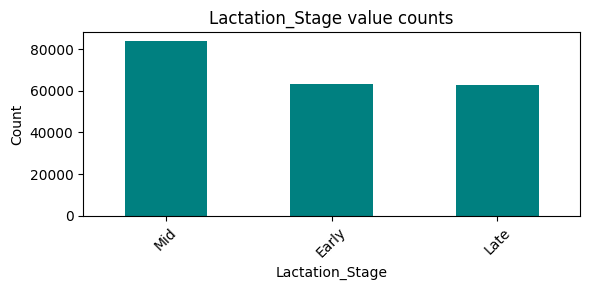

In [65]:
'''Counts of our categorical features should give us a better idea of how to encode them'''

cats = ['Breed', 'Climate_Zone', 'Management_System', 'Feed_Type', 'Lactation_Stage']
df = trainData.copy()
for col in cats:
    if col in df.columns:
        plt.figure(figsize=(6,3))
        df[col].value_counts().nlargest(20).plot(kind='bar', color='teal')
        plt.title(f'{col} value counts')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.tight_layout()

'''Professor Beasley definitely added those breed misspellings''';

### Time

'Gradual increase in milk yield over the academic year, with a steep decline during the summer.'

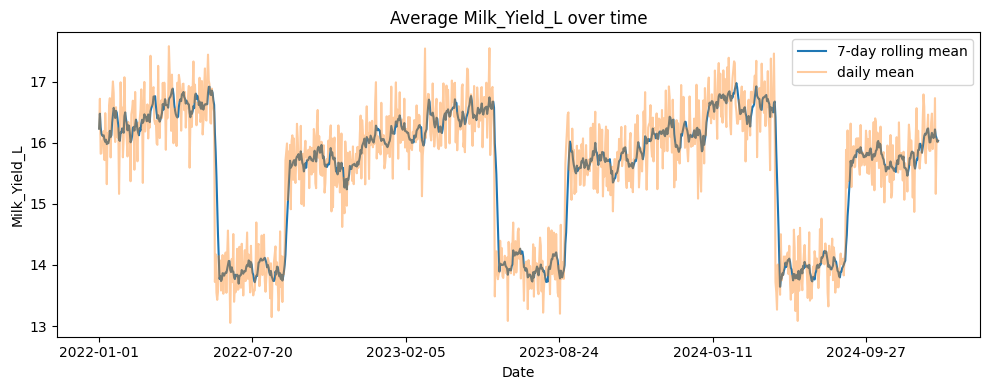

In [ ]:
'''Milk yield over time'''

ts = df.groupby('Date')['Milk_Yield_L'].mean().dropna()
if len(ts) > 1:
    plt.figure(figsize=(10,4))
    ts.rolling(7, min_periods=1).mean().plot(label='7-day rolling mean')
    ts.plot(alpha=0.4, label='daily mean')
    plt.title('Average Milk_Yield_L over time')
    plt.ylabel('Milk_Yield_L')
    plt.legend()
    plt.tight_layout()

'''Gradual increase in milk yield over the academic year, with a steep decline during the summer.''';

# Feature Engineering

### Data Encoding

Reference

In [67]:
'''Reference train data and trainer. Tolerating mild leakage for now. 
We can do CV experiments with a tuned model once we have some good directionality'''
refTrainData = pd.read_csv("cattle_data_train.csv")
refTrainData.drop(columns="Cattle_ID")

# GBM to train for FE experiments
def GBM_trainer(df):
    hf = h2o.H2OFrame(df)
    y = "Milk_Yield_L"
    x = [c for c in hf.columns if c != y]

    gbm = H2OGradientBoostingEstimator(
        ntrees=300,
        max_depth=6,
        learn_rate=0.05,
        seed=36,
        nfolds=5,
        fold_assignment="Modulo",
        score_tree_interval=300
    )

    gbm.train(x=x, y=y, training_frame=hf)

    rmse = gbm.rmse(xval=True)

    return rmse, gbm

baseline_rmse, baseline_gbm = GBM_trainer(refTrainData.copy())

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


In [68]:
'''Hypothesis
Farm_ID is the most predictive feature based on varimp. It's implicitly capturing differences
between farms, so we should try and engineer additional clarity. Target encoding Farm_ID
and Milk_Yield_L will enhance our model. We can try both mean and std. 
Lactation stage is implicitly ordinal, so lets try ordinal encoding. 
Finally, date is currently useless in its current form, we can get much more from 
pulling out months and days. Skipping encoding for management systems, feed types, climate zone, 
and breed for now.'''

# Make a copy from the cleaned reference
df_de = refTrainData.copy()

# 1. Lactation stage ordinal
# stage_order = ["Early", "Mid", "Late"]
# stage_mapping = {stage: i for i, stage in enumerate(stage_order)}
# df_de["Lactation_Stage_Ord"] = df_de["Lactation_Stage"].map(stage_mapping).astype("int8")
# df_de.drop(columns=["Lactation_Stage"], inplace=True)

# 2. Date -> Month + DayOfYear
df_de["Date"] = pd.to_datetime(df_de["Date"])
df_de["Month"] = df_de["Date"].dt.month
df_de["DayOfYear"] = df_de["Date"].dt.dayofyear
df_de.drop(columns=["Date"], inplace=True)

# 3. Farm_ID -> Farm_STD
farm_std_map = df_de.groupby("Farm_ID")["Milk_Yield_L"].std()
# farm_mean_map = df_de.groupby("Farm_ID")["Milk_Yield_L"].mean()
df_de["Farm_STD"] = df_de["Farm_ID"].map(farm_std_map)
# df_de["Farm_Mean"] = df_de["Farm_ID"].map(farm_mean_map)
df_de.drop(columns=["Farm_ID"], inplace=True)

de_rmse, de_gbm = GBM_trainer(df_de)

print("Baseline RMSE:", baseline_rmse)
print("DE RMSE:", de_rmse)
print("Δ RMSE:", de_rmse - baseline_rmse)

'''Conclusion
After mixing and matching the combinations, Date and Farm_ID encodings improve
model performance quite substantially together. For some reason, making
lactation stage ordinal was more of a hindrance. I'm thinking its because H2OGBMs 
internal handling of the raw category is just better. Also, STD encoding farm
is better than mean. I'm thinking this is because STD is just more unique
and newer data. Probably helps the model with predicting the variation within
a farm as opposed to just between farms?''';


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Baseline RMSE: 4.3650996260451524
DE RMSE: 4.123684712131155
Δ RMSE: -0.2414149139139976


In [72]:
'''Hypothesis
Introducing seasonality might improve performance. In the previous cell, we introduced 
months and days as linear, but they are cyclical. We can categorize into seasons, 
and see which combination of month, days, and seasons is best. '''

''' We'll add a seasons category, and then apply sin/cosine to mimic the cyclic
nature of day and month'''

df_atime = refTrainData.copy()

df_atime["Date"] = pd.to_datetime(df_atime["Date"])
df_atime["Month"] = df_atime["Date"].dt.month
df_atime["DayOfYear"] = df_atime["Date"].dt.dayofyear

# Seasons
def month_to_season(m):
    if m in [12, 1, 2]:
        return "Winter"
    elif m in [3, 4, 5]:
        return "Spring"
    elif m in [6, 7, 8]:
        return "Summer"
    else:
        return "Fall"

df_atime["Season"] = df_atime["Month"].apply(month_to_season)

# ---- Cyclic encodings (Month)
# df_atime["Month_sin"] = np.sin(2 * np.pi * df_atime["Month"] / 12)
# df_atime["Month_cos"] = np.cos(2 * np.pi * df_atime["Month"] / 12)
# # ---- Cyclic encodings (DayOfYear)
# df_atime["Day_sin"] = np.sin(2 * np.pi * df_atime["DayOfYear"] / 365)
# df_atime["Day_cos"] = np.cos(2 * np.pi * df_atime["DayOfYear"] / 365)

df_atime.drop(columns=["Date"], inplace=True)
# df_atime.drop(columns=["Month"], inplace=True)
df_atime.drop(columns=["DayOfYear"], inplace=True)

de_rmse, de_gbm = GBM_trainer(df_atime)

print("Baseline RMSE:", baseline_rmse)
print("Seasons RMSE:", de_rmse)
print("Δ RMSE:", de_rmse - baseline_rmse)

'''Conclusion
The best combination is season + month. Day worsens performance in every way, and the sincos
month is about identical to just month, so we can just keep things simple.''';

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Baseline RMSE: 4.3650996260451524
Seasons RMSE: 4.331708720192189
Δ RMSE: -0.033390905852963115


In [30]:
'''Hypothesis
Maybe we can further complicate farm_STD. This is a golden feature that captured STD to differentiate
farms. But maybe there's a formula to incorporate both mean and STD. Or maybe just other features 
to aggregate that provide new information similar to STD.'''

'''mean, median, iqr, min, max, count'''

''' coefficients e.g. std/mean, z normalized, a stability score 1/STD '''

df_farm = refTrainData.copy()

# Get farm-level mean and std
farm_stats = df_farm.groupby("Farm_ID")["Milk_Yield_L"].agg(Farm_Mean="mean", Farm_Std="std")

# Target encode
# df_farm["Farm_Mean_Yield"] = df_farm["Farm_ID"].map(farm_stats["Farm_Mean"])
df_farm["Farm_Std_Yield"]  = df_farm["Farm_ID"].map(farm_stats["Farm_Std"])

# Drop the raw Farm_ID
df_farm.drop(columns=["Farm_ID"], inplace=True)

rmse_farm, gbm_farm = GBM_trainer(df_farm)

print("Baseline RMSE:", baseline_rmse)
print("Adv.Farm RMSE:", rmse_farm)
print("Δ RMSE:", rmse_farm - baseline_rmse)

'''Conclusion
No, STD is best by itself.'''

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Baseline RMSE: 4.3650996260451524
Adv.Farm RMSE: 4.123025033516905
Δ RMSE: -0.24207459252824748


'Conclusion\nNo, STD is best by itself.'

# Preprocessor

In [ ]:
'''Preprocessor for ensuring we aren't leaking data into the test or validation sets when
performing cross validation'''

class Preprocessor:
    def __init__(self):
        self.clean_stats = {}
        self.fe_stats = {}

    '''fit computes and stores training set imputations/target encodings. It then applies
    these transformations to the training set.'''
    def fit(self, df, target="Milk_Yield_L"):
        df = df.copy()

        # Remove negative target milk yields
        df = df[df[target] >= 0]

        # Correct misspelled breeds
        df["Breed"] = df["Breed"].str.strip().replace({"Holstien": "Holstein"})

        # Remove duplicate cows
        df = df[~df["Cattle_ID"].duplicated(keep=False)]

        # Get month from date for target encoding
        df["Month"] = pd.to_datetime(df["Date"], errors="coerce").dt.month

        # Save imputations from train to apply to train/val/test
        self.clean_stats["rumination_min"] = df["Rumination_Time_hrs"].min()
        self.clean_stats["feed_lb_by_farm"] = df.groupby("Farm_ID")["Feed_Quantity_lb"].mean()
        self.clean_stats["feed_kg_by_farm"] = df.groupby("Farm_ID")["Feed_Quantity_kg"].mean()
        self.clean_stats["housing_by_farm"] = df.groupby("Farm_ID")["Housing_Score"].mean()

        # Save target encodings from train to apply to train/val/test
        self.fe_stats["farm_std"] = df.groupby("Farm_ID")[target].std()
        self.fe_stats["month_mean"] = df.groupby("Month")[target].mean()

        ''''''
        # TESTS
        ''''''

        # Apply transformations just to train
        df = self._apply_transform(df)

        y = df[target].copy()
        X = df.drop(columns=[target], errors="ignore")

        return X, y

    '''transform applies training sets stored imputes/encodes to the validation and testing
    sets. This split prevents leakage, as we're computing something like mean only on
    the training set and then applying that to val/test. No val/test data used in these
    computations.'''
    def transform(self, df, target="Milk_Yield_L", has_target=True):
        df = df.copy()

        # Correct misspelled breeds
        df["Breed"] = df["Breed"].str.strip().replace({"Holstien": "Holstein"})

        # Grab month from date
        df["Month"] = pd.to_datetime(df["Date"], errors="coerce").dt.month

        # Apply transformations
        df = self._apply_transform(df)

        y = df[target].copy() if (has_target and target in df.columns) else None
        X = df.drop(columns=target, errors="ignore")

        return X, y

    # Applying transformations train/val/test
    def _apply_transform(self, df):
        df = df.copy()

        # Rumination shift
        df["Rumination_Time_hrs"] = df["Rumination_Time_hrs"] - self.clean_stats["rumination_min"]

        # NaN imputations
        df["Feed_Quantity_lb"] = df["Feed_Quantity_lb"].fillna(df["Farm_ID"].map(self.clean_stats["feed_lb_by_farm"]))
        df["Feed_Quantity_kg"] = df["Feed_Quantity_kg"].fillna(df["Farm_ID"].map(self.clean_stats["feed_kg_by_farm"]))
        df["Housing_Score"] = df["Housing_Score"].fillna(df["Farm_ID"].map(self.clean_stats["housing_by_farm"]))

        # Target encodings
        df["Farm_Std_Yield"] = df["Farm_ID"].map(self.fe_stats["farm_std"])
        df["Month_Mean_Yield"] = df["Month"].map(self.fe_stats["month_mean"])
            
        # Drop
        df = df.drop(columns=["Cattle_ID", "Date", "Farm_ID", "Month", "Feed_Quantity_kg"], errors="ignore")

        # Feature interactions
        df["Water_FeedLB_Product"] = df["Water_Intake_L"] * df["Feed_Quantity_lb"]
        df["Water_per_lb"] = df["Water_Intake_L"] / df["Feed_Quantity_lb"]
        df["Rumi_per_lb"] = df["Rumination_Time_hrs"] / df["Feed_Quantity_lb"]

        ''''''
        # TESTS
        ''''''

        return df

In [69]:
'''Now that our preprocessor is setup, we can just make changes to the preprocessor, and then 
run cross validaiton in our modeling approach section. We'll document our results in the following cells.''';

### Feature Interactions

In [70]:
'''Hypothesis
We can improve the models predictions by introducing features interactions. e.g. a heavy cow with poor rumination could indicate
health issues. We have a SHAP heatmap for reference in our modeling approach section.

Top Interaction Strengths
Feature 1               Feature 2                 Score
Water_Intake_L          Feed_Quantity_lb          1.4006
Weight_kg               Month_Mean_Yield          1.3059
Feed_Quantity_kg        Water_Intake_L            1.2140
Age_Months              Farm_Std_Yield            1.2042
Age_Months              Weight_kg                 1.1342
Weight_kg               Days_in_Milk              1.1154
Age_Months              Water_Intake_L            1.0721
Weight_kg               Farm_Std_Yield            1.0664
Days_in_Milk            Farm_Std_Yield            1.0514
Breed                   Management_System         1.0251
Age_Months              Days_in_Milk              1.0113
Days_in_Milk            Water_Intake_L            0.8930
Weight_kg               Parity                    0.8820
Days_in_Milk            Resting_Hours             0.8701
Weight_kg               Water_Intake_L            0.8285
Days_in_Milk            Ambient_Temperature_C     0.8241
Ambient_Temperature_C   Farm_Std_Yield            0.8147
Parity                  Month_Mean_Yield          0.7869
Breed                   Lactation_Stage           0.7675
Breed                   Climate_Zone              0.7674

Now, we'll want to try interactions backed by both SHAP and cow knowledge
'''

df = pd.read_csv("cattle_data_train.csv")

# 1. Water & Feed - water intake * dry matter intake (DMI)
df["Water_FeedLB_Product"] = df["Water_Intake_L"] * df["Feed_Quantity_lb"]

#2. DIM & Temperature - heat stress
df["DIM_Temp"] = df["Days_in_Milk"] * df["Ambient_Temperature_C"]

#3. DIM & Feed - DMI curve
df["DIM_FeedLB"] = df["Days_in_Milk"] * df["Feed_Quantity_lb"]

#4. DIM & Age - old cows & woods lactation curve
df["DIM_Age"] = df["Age_Months"] * df["Days_in_Milk"]

#5. DIM & Water - water
df["DIM_Water"] = df["Days_in_Milk"] * df["Water_Intake_L"]

'''Only #1 improved RMSE'''

'''There's actually features on the heatmap that are dark but backed biologically. It might actually be
better to focus on making sure the model is capturing these features, as opposed to reinforcing already 
captured ones.'''

#1. THI
df["TempHumid_interaction"] = df["Ambient_Temperature_C"] * df["Humidity_percent"]

#2. Body condition score and feed
df["BCS_FeedLB"] = df["Body_Condition_Score"] * df["Feed_Quantity_lb"]

'''Nothing burger''';

### Data Encoding Pt.2

In [71]:
'''The date feature gave the second largest rmse improve next to farm_id. We should milk it. 
It might actually be a better idea to just target encode month and remove seasons. '''

# Target encode month
df["Month"] = pd.to_datetime(df["Date"], errors="coerce").dt.month
month_means = df.groupby("Month")["Milk_Yield_L"].mean()
df["Month_TE"] = df["Month"].map(month_means)

'''This improved RMSE'''

''' We wanted to encode breed, management systems, feed types, climate, and lactation stage.
After looking at their count graphs and trying frequency encoding, we figured it wasn't providing
valuable new information since the distributions were very similar. We also had no success
with one-hot encoding because all our models could just automatically handle categorical 
encodings themselves and do so better. 

Post leaderboard note: we target encoded breed in the public leaderboard submission, but discovered 
really late that this was hurting generalization (private leaderboard score was better without)
''';

# Modeling Approach

### Cross Validation

In [90]:
''' Performing cross validation with preprocessing and the best performing gbm thus far.

This is how we'll test cleaning/feature engineering until submission. First update
the Preprocessor class, and then run this cross validation. If RMSE improves, keep
the changes. If we find a better model or hyperparameters, switch to that.
'''

data = pd.read_csv("cattle_data_train.csv")

best_lgb_params = {
    "objective": "regression",
    "metric": "rmse",
    "verbosity": -1,
    "seed": 36,
    "learning_rate": 0.020819964609680587,
    "max_depth": 3,
    "num_leaves": 6,
    "min_data_in_leaf": 219,
    "feature_fraction": 0.3847672743455994,
    "bagging_fraction": 0.8946508983501325,
    "bagging_freq": 4,
    "lambda_l1": 1.5022412461355996,
    "lambda_l2": 1.66826376440505,
    "max_bin": 112
}

best_lgb_n_estimators = 1810

kf = KFold(n_splits=5, shuffle=True, random_state=36)
rmse_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(data), 1):

    train_df = data.iloc[train_idx].copy()
    val_df   = data.iloc[val_idx].copy()

    pre = Preprocessor()
    X_tr, y_tr = pre.fit(train_df)
    X_val, y_val = pre.transform(val_df)

    for col in X_tr.select_dtypes(include="object").columns:
        X_tr[col] = X_tr[col].astype("category")
        X_val[col] = X_val[col].astype("category")

    cat_cols = [i for i, col in enumerate(X_tr.columns) if X_tr[col].dtype.name == "category"]

    train_data = lgb.Dataset(X_tr, label=y_tr, categorical_feature=cat_cols)
    valid_data = lgb.Dataset(X_val, label=y_val, categorical_feature=cat_cols)

    model = lgb.train(
        params=best_lgb_params,
        train_set=train_data,
        num_boost_round=best_lgb_n_estimators,
        valid_sets=[valid_data],
        callbacks=[lgb.early_stopping(stopping_rounds=40),
                   lgb.log_evaluation(period=0)],
    )

    preds = model.predict(X_val)
    rmse = root_mean_squared_error(y_val, preds)

    rmse_scores.append(rmse)
    print(f"Fold {fold} RMSE: {rmse:.5f}")

print("\nMean RMSE:", np.mean(rmse_scores))

Training until validation scores don't improve for 40 rounds
Early stopping, best iteration is:
[1290]	valid_0's rmse: 4.13078
Fold 1 RMSE: 4.13078
Training until validation scores don't improve for 40 rounds
Early stopping, best iteration is:
[1352]	valid_0's rmse: 4.12414
Fold 2 RMSE: 4.12414
Training until validation scores don't improve for 40 rounds
Early stopping, best iteration is:
[1141]	valid_0's rmse: 4.10952
Fold 3 RMSE: 4.10952
Training until validation scores don't improve for 40 rounds
Early stopping, best iteration is:
[1394]	valid_0's rmse: 4.09934
Fold 4 RMSE: 4.09934
Training until validation scores don't improve for 40 rounds
Early stopping, best iteration is:
[1367]	valid_0's rmse: 4.10126
Fold 5 RMSE: 4.10126

Mean RMSE: 4.113005627709637


### GBM Optuna

In [ ]:
'''We only want to work with gradient boosting machines. They're just generally higher performing and accurate,
especially on tabular data like ours. Every GBM is different e.g. CatBoost is particularly good at handling
categorical data sets. We want to try as many as we can.

Using Optuna for tuning. Optuna makes the tuning process much faster as it's able to prune hyperparameter combinations
that it decides aren't worth training further. 


https://www.geeksforgeeks.org/machine-learning/gradientboosting-vs-adaboost-vs-xgboost-vs-catboost-vs-lightgbm/
'''

XGB Optuna

In [ ]:
''' Setting up XGB's Optuna with our cross validation and preprocessing setup. This defines
an 'objective' which we will run trials on. After tuning, we can tighten a hyperparameter
if it appeared to be centered within our set range, or broadened if it looked to be bordering 
our set range.

Everytime we introduce better cleaning or feature engineering, we re-tune and adjust params
within the objective function.
'''

DATA = pd.read_csv("cattle_data_train.csv")


# OBJECTIVE
def objective_xgb(trial):

    data = DATA.copy()

    # Hyperparameters set range
    params = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "tree_method": "hist",
        "seed": 36,
        "eta": trial.suggest_float("eta", 0.055, 0.082),
        "max_depth": trial.suggest_int("max_depth", 3, 3),
        "min_child_weight": trial.suggest_int("min_child_weight", 9, 15),
        "subsample": trial.suggest_float("subsample", 0.77, 0.86),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.62, 0.74),
        "gamma": trial.suggest_float("gamma", 0.0, 0.03),
        "max_bin": trial.suggest_int("max_bin", 96, 132),
        "reg_alpha": trial.suggest_float("reg_alpha", 1.6, 2.3),
        "reg_lambda": trial.suggest_float("reg_lambda", 2.0, 2.8),
        "num_parallel_tree": 1,
    }

    n_estimators = trial.suggest_int("n_estimators", 1450, 2100)
    
    # Cross validation
    kf = KFold(n_splits=5, shuffle=True, random_state=36)
    rmse_scores = []

    for fold_idx, (tr_idx, val_idx) in enumerate(kf.split(data), start=1):

        train_df = data.iloc[tr_idx].copy()
        val_df   = data.iloc[val_idx].copy()

        # Preprocess
        pre = Preprocessor()
        X_tr, y_tr = pre.fit(train_df)
        X_val, y_val = pre.transform(val_df)

        for col in X_tr.select_dtypes(include="object").columns:
            X_tr[col] = X_tr[col].astype("category")
        for col in X_val.select_dtypes(include="object").columns:
            X_val[col] = X_val[col].astype("category")

        dtrain = xgb.DMatrix(X_tr, label=y_tr, enable_categorical=True)
        dval   = xgb.DMatrix(X_val, label=y_val, enable_categorical=True)

        model = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=n_estimators,
            evals=[(dval, "valid")],
            early_stopping_rounds=50,
            verbose_eval=False,
        )

        preds = model.predict(dval)
        rmse = root_mean_squared_error(y_val, preds)
        rmse_scores.append(rmse)

        trial.report(rmse, fold_idx)
        if trial.should_prune():
            raise optuna.TrialPruned()

    return np.mean(rmse_scores)

In [ ]:
''' Okay so we're only running 1 trial here for submission, but the next print cell was our results
of the study, and also the params for our leaderboard submission'''

# Run the Optuna study
study_xgb = optuna.create_study(
    direction="minimize",
    sampler=TPESampler(seed=36),
    pruner=MedianPruner(n_startup_trials=5),
)

study_xgb.optimize(objective_xgb, n_trials=1)

[I 2025-11-24 20:48:12,771] A new study created in memory with name: no-name-39d47f33-1a8f-4813-911b-25180eaeb29c
[I 2025-11-24 20:48:21,883] Trial 0 finished with value: 4.117171052016003 and parameters: {'eta': 0.0746696941730846, 'max_depth': 3, 'min_child_weight': 13, 'subsample': 0.8556962600665412, 'colsample_bytree': 0.6371808137265237, 'gamma': 0.02422077389610494, 'max_bin': 109, 'reg_alpha': 1.7305897686025211, 'reg_lambda': 2.2073209906303575, 'n_estimators': 1859}. Best is trial 0 with value: 4.117171052016003.


In [ ]:
'''Results'''
print("Best RMSE:", study_xgb.best_value)
print("Best Params:", study_xgb.best_params)

Best RMSE: 4.115045559182258
Best Params: {'eta': 0.05571663480422255, 'max_depth': 3, 'min_child_weight': 14, 'subsample': 0.8082650461925075, 'colsample_bytree': 0.7086494032288356, 'gamma': 0.0025236658744077394, 'max_bin': 103, 'reg_alpha': 2.194000695011386, 'reg_lambda': 2.0056050432141928, 'n_estimators': 1776}


LGB Optuna

In [ ]:
''' Identical process to XGB '''
import lightgbm as lgb

DATA = pd.read_csv("cattle_data_train.csv")

def objective_lgb(trial):

    data = DATA.copy()

    params = {
        "objective": "regression",
        "metric": "rmse",
        "verbosity": -1,
        "seed": 36,

        "learning_rate": trial.suggest_float("learning_rate", 0.015, 0.035),
        "max_depth": trial.suggest_int("max_depth", 2, 3),
        "num_leaves": trial.suggest_int("num_leaves", 5, 10),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 180, 300),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.32, 0.48),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.80, 0.97),
        "bagging_freq": trial.suggest_int("bagging_freq", 3, 6),
        "lambda_l1": trial.suggest_float("lambda_l1", 1.2, 2.2),
        "lambda_l2": trial.suggest_float("lambda_l2", 1.2, 2.2),
        "max_bin": trial.suggest_int("max_bin", 96, 140, step=4),
    }

    n_estimators = trial.suggest_int("n_estimators", 1600, 2600)

    kf = KFold(n_splits=5, shuffle=True, random_state=36)
    rmse_scores = []

    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(data), start=1):

        train_df = data.iloc[train_idx].copy()
        val_df   = data.iloc[val_idx].copy()

        pre = Preprocessor()
        X_tr, y_tr = pre.fit(train_df)
        X_val, y_val = pre.transform(val_df)

        for col in X_tr.select_dtypes(include="object").columns:
            X_tr[col] = X_tr[col].astype("category")
        for col in X_val.select_dtypes(include="object").columns:
            X_val[col] = X_val[col].astype("category")

        cat_cols = [i for i, col in enumerate(X_tr.columns) if X_tr[col].dtype.name == "category"]

        train_data = lgb.Dataset(X_tr, label=y_tr, categorical_feature=cat_cols)
        valid_data = lgb.Dataset(X_val, label=y_val, categorical_feature=cat_cols)

        model = lgb.train(
            params=params,
            train_set=train_data,
            num_boost_round=n_estimators,
            valid_sets=[valid_data],
            callbacks=[
                lgb.early_stopping(stopping_rounds=40),
                lgb.log_evaluation(period=0),
            ],
        )

        preds = model.predict(X_val)
        rmse = root_mean_squared_error(y_val, preds)
        rmse_scores.append(rmse)

        trial.report(rmse, fold_idx)
        if trial.should_prune():
            raise optuna.TrialPruned()

    return np.mean(rmse_scores)

In [217]:
study_lgb = optuna.create_study(
    direction="minimize",
    sampler=TPESampler(seed=36),
    pruner=MedianPruner(n_startup_trials=5),
)

study_lgb.optimize(objective_lgb, n_trials=1, show_progress_bar=False)

[I 2025-11-24 20:48:42,379] A new study created in memory with name: no-name-c3a1fbc1-56d7-4992-b88f-d122e156916b


Training until validation scores don't improve for 40 rounds
Early stopping, best iteration is:
[885]	valid_0's rmse: 4.13271
Training until validation scores don't improve for 40 rounds
Early stopping, best iteration is:
[840]	valid_0's rmse: 4.12429
Training until validation scores don't improve for 40 rounds
Early stopping, best iteration is:
[706]	valid_0's rmse: 4.11072
Training until validation scores don't improve for 40 rounds
Early stopping, best iteration is:
[945]	valid_0's rmse: 4.09989
Training until validation scores don't improve for 40 rounds


[I 2025-11-24 20:48:55,722] Trial 0 finished with value: 4.114139457371456 and parameters: {'learning_rate': 0.029570143831914517, 'max_depth': 3, 'num_leaves': 10, 'min_data_in_leaf': 197, 'feature_fraction': 0.4491774607792264, 'bagging_fraction': 0.8617464814085749, 'bagging_freq': 3, 'lambda_l1': 1.4591512382879472, 'lambda_l2': 1.8297623426119494, 'max_bin': 96, 'n_estimators': 2548}. Best is trial 0 with value: 4.114139457371456.


Early stopping, best iteration is:
[859]	valid_0's rmse: 4.10309


In [ ]:
print("Best LGBM RMSE:", study_lgb.best_value)
print("Best LGBM Params:", study_lgb.best_params)

Best LGBM RMSE: 4.11202398595223
Best LGBM Params: {'learning_rate': 0.034892234976012036, 'max_depth': 3, 'num_leaves': 5, 'min_data_in_leaf': 240, 'feature_fraction': 0.32342357587298376, 'bagging_fraction': 0.9177082457956935, 'bagging_freq': 4, 'lambda_l1': 1.6818582690930826, 'lambda_l2': 1.2474491844647437, 'max_bin': 140, 'n_estimators': 1674}


CAT Optuna

In [ ]:
''' Identical process to XGB and LGB'''
DATA = pd.read_csv("cattle_data_train.csv")

def objective_cat(trial):

    data = DATA.copy()

    params = {
        "loss_function": "RMSE",
        "eval_metric": "RMSE",
        "random_seed": 36,
        "verbose": False,

        "learning_rate": trial.suggest_float("learning_rate", 0.040, 0.055),
        "depth": trial.suggest_int("depth", 6, 7),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 4.5, 7.5),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.30, 0.60),
        "border_count": trial.suggest_int("border_count", 148, 170),
        "random_strength": trial.suggest_float("random_strength", 1.0, 1.7),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 35, 65),
    }

    n_estimators = trial.suggest_int("n_estimators", 850, 1150)

    n_estimators = trial.suggest_int("n_estimators", 850, 1450)

    kf = KFold(n_splits=5, shuffle=True, random_state=36)
    rmse_scores = []

    for fold_idx, (tr_idx, val_idx) in enumerate(kf.split(data), start=1):

        train_df = data.iloc[tr_idx].copy()
        val_df   = data.iloc[val_idx].copy()

        pre = Preprocessor()
        X_tr, y_tr = pre.fit(train_df)
        X_val, y_val = pre.transform(val_df)

        cat_cols = [i for i, col in enumerate(X_tr.columns) if X_tr[col].dtype == "object"]

        train_pool = Pool(X_tr, label=y_tr, cat_features=cat_cols)
        val_pool   = Pool(X_val, label=y_val, cat_features=cat_cols)

        model = CatBoostRegressor(
            **params,
            iterations=n_estimators,
            od_wait=40,
            use_best_model=True
        )

        model.fit(train_pool, eval_set=val_pool)

        preds = model.predict(X_val)
        rmse = root_mean_squared_error(y_val, preds)
        rmse_scores.append(rmse)

        trial.report(rmse, fold_idx)
        if trial.should_prune():
            raise optuna.TrialPruned()

    return np.mean(rmse_scores)

In [219]:
study_cat = optuna.create_study(
    direction="minimize",
    sampler=TPESampler(seed=36),
    pruner=MedianPruner(n_startup_trials=5)
)

study_cat.optimize(objective_cat, n_trials=1, show_progress_bar=False)

[I 2025-11-24 20:48:56,160] A new study created in memory with name: no-name-75e56fad-a353-4f18-a41d-5e1d303ae6d5
[I 2025-11-24 20:50:49,206] Trial 0 finished with value: 4.1132836985578916 and parameters: {'learning_rate': 0.05092760787393588, 'depth': 7, 'l2_leaf_reg': 7.356542002218041, 'bagging_temperature': 0.3429520343163091, 'border_count': 166, 'random_strength': 1.2542502175647203, 'min_data_in_leaf': 40, 'n_estimators': 928}. Best is trial 0 with value: 4.1132836985578916.


In [ ]:
print("Best CatBoost RMSE:", study_cat.best_value)
print("Best CatBoost Params:", study_cat.best_params)

Best CatBoost RMSE: 4.112509597096428
Best CatBoost Params: {'learning_rate': 0.047705512500353354, 'depth': 6, 'l2_leaf_reg': 6.393725039607688, 'bagging_temperature': 0.3966836695930784, 'border_count': 154, 'random_strength': 1.3305439568539597, 'min_data_in_leaf': 48, 'n_estimators': 949}


H2O Optuna

In [ ]:
'''Identical process to previous GBMs'''
from h2o.estimators import H2OGradientBoostingEstimator

data_raw = pd.read_csv("cattle_data_train.csv")

y_col = "Milk_Yield_L"

def objective_h2o_gbm(trial):

    params = {
        "learn_rate": trial.suggest_float("learn_rate", 0.07, 0.13),
        "max_depth": trial.suggest_int("max_depth", 3, 6),
        "min_rows": trial.suggest_int("min_rows", 15, 45),
        "sample_rate": trial.suggest_float("sample_rate", 0.4, 0.7),
        "col_sample_rate": trial.suggest_float("col_sample_rate", 0.8, 1.0),
        "col_sample_rate_per_tree": trial.suggest_float("col_sample_rate_per_tree", 0.3, 0.6),
        "ntrees": trial.suggest_int("ntrees", 80, 200),
    }

    kf = KFold(n_splits=3, shuffle=True, random_state=36)
    rmses = []

    for tr_idx, val_idx in kf.split(data_raw):
        
        train_df = data_raw.iloc[tr_idx].copy()
        val_df   = data_raw.iloc[val_idx].copy()

        pre = Preprocessor()
        X_tr, y_tr = pre.fit(train_df)
        X_val, y_val = pre.transform(val_df)

        h2o_tr = h2o.H2OFrame(X_tr.assign(Milk_Yield_L=y_tr))
        h2o_val = h2o.H2OFrame(X_val.assign(Milk_Yield_L=y_val))

        x_cols = X_tr.columns.tolist()

        model = H2OGradientBoostingEstimator(
            **params,
            seed=36
        )

        model.train(
            x=x_cols,
            y=y_col,
            training_frame=h2o_tr,
            validation_frame=h2o_val
        )

        preds = model.predict(h2o_val).as_data_frame().values.flatten()

        rmse = root_mean_squared_error(y_val, preds)
        rmses.append(rmse)

    return np.mean(rmses)

In [221]:
study = optuna.create_study(direction="minimize")
study.optimize(objective_h2o_gbm, n_trials=1)

[I 2025-11-24 20:50:49,599] A new study created in memory with name: no-name-9b02fbdd-86ad-40d0-94c4-9bde82e1ad3e


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |███████████████████████

[I 2025-11-24 20:52:51,210] Trial 0 finished with value: 4.148810576399456 and parameters: {'learn_rate': 0.11201037669017455, 'max_depth': 6, 'min_rows': 30, 'sample_rate': 0.42669580606011037, 'col_sample_rate': 0.8506530381256534, 'col_sample_rate_per_tree': 0.5278812547780853, 'ntrees': 195}. Best is trial 0 with value: 4.148810576399456.


In [ ]:
print("Best H2O GBM RMSE:", study.best_value)
print("Best H2O GBM Params:", study.best_params)

Best H2O GBM RMSE: 4.1204857143149605
Best H2O GBM Params: {'learn_rate': 0.12068772759630972, 'max_depth': 3, 'min_rows': 15, 'sample_rate': 0.6476100491682713, 'col_sample_rate': 0.9405846399952908, 'col_sample_rate_per_tree': 0.449186513500338, 'ntrees': 164}


In [12]:
''' Model comparison '''
# H2O GBM RMSE: 4.1205 - terrible
# CatBoost RMSE: 4.1125
# LightGBM RMSE: 4.1120
# XGBoost RMSE: 4.1150

' Model comparison '

### Ensembling

In [7]:
''' Here were our best params after finishing preprocessing and Optuna tuning '''

best_xgb_params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "tree_method": "hist",
    "seed": 36,
    "eta": 0.05571663480422255,
    "max_depth": 3,
    "min_child_weight": 14,
    "subsample": 0.8082650461925075,
    "colsample_bytree": 0.7086494032288356,
    "gamma": 0.0025236658744077394,
    "max_bin": 103,
    "reg_alpha": 2.194000695011386,
    "reg_lambda": 2.0056050432141928,
}
best_xgb_n_estimators = 1776

best_lgb_params = {
    "objective": "regression",
    "metric": "rmse",
    "verbosity": -1,
    "seed": 36,
    "learning_rate": 0.034892234976012036,
    "max_depth": 3,
    "num_leaves": 5,
    "min_data_in_leaf": 240,
    "feature_fraction": 0.32342357587298376,
    "bagging_fraction": 0.9177082457956935,
    "bagging_freq": 4,
    "lambda_l1": 1.6818582690930826,
    "lambda_l2": 1.2474491844647437,
    "max_bin": 140,
}
best_lgb_n_estimators = 1674

best_cat_params = {
    "learning_rate": 0.047705512500353354,
    "depth": 6,
    "l2_leaf_reg": 6.393725039607688,
    "bagging_temperature": 0.3966836695930784,
    "border_count": 154,
    "random_strength": 1.3305439568539597,
    "min_data_in_leaf": 48,
}
best_cat_n_estimators = 949

In [ ]:
''' Stacked ensemble with XGB, LGB, & CAT. Excluding H2O because its slow and sucks '''

from sklearn.linear_model import ElasticNetCV

data = pd.read_csv("cattle_data_train.csv")

n = len(data)

# oof
oof_preds_xgb = np.zeros(n)
oof_preds_lgb = np.zeros(n)
oof_preds_cat = np.zeros(n)
oof_y = np.zeros(n)

# Cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=36)

for fold, (tr_idx, val_idx) in enumerate(kf.split(data), 1):

    train_df = data.iloc[tr_idx].copy()
    val_df   = data.iloc[val_idx].copy()

    pre = Preprocessor()
    X_tr, y_tr = pre.fit(train_df)
    X_val, y_val = pre.transform(val_df)

    oof_y[val_idx] = y_val.values

    # XGB
    X_tr_xgb = X_tr.copy()
    X_val_xgb = X_val.copy()

    for col in X_tr_xgb.select_dtypes(include="object").columns:
        X_tr_xgb[col] = X_tr_xgb[col].astype("category")
        X_val_xgb[col] = X_val_xgb[col].astype("category")

    dtrain = xgb.DMatrix(X_tr_xgb, label=y_tr, enable_categorical=True)
    dval   = xgb.DMatrix(X_val_xgb, label=y_val, enable_categorical=True)

    model_xgb = xgb.train(
        params=best_xgb_params,
        dtrain=dtrain,
        num_boost_round=best_xgb_n_estimators,
        verbose_eval=False
    )
    oof_preds_xgb[val_idx] = model_xgb.predict(dval)

    # LGB
    X_tr_lgb = X_tr.copy()
    X_val_lgb = X_val.copy()

    for col in X_tr_lgb.select_dtypes(include="object").columns:
        X_tr_lgb[col] = X_tr_lgb[col].astype("category")
        X_val_lgb[col] = X_val_lgb[col].astype("category")

    cat_cols_lgb = [i for i, col in enumerate(X_tr_lgb.columns) if X_tr_lgb[col].dtype.name == "category"]

    train_data = lgb.Dataset(X_tr_lgb, label=y_tr, categorical_feature=cat_cols_lgb)
    valid_data = lgb.Dataset(X_val_lgb, label=y_val, categorical_feature=cat_cols_lgb)

    model_lgb = lgb.train(
        params=best_lgb_params,
        train_set=train_data,
        num_boost_round=best_lgb_n_estimators,
        valid_sets=[valid_data],
        callbacks=[lgb.early_stopping(stopping_rounds=40),
                   lgb.log_evaluation(period=0)],
    )
    oof_preds_lgb[val_idx] = model_lgb.predict(X_val_lgb)

    # CAT
    X_tr_cat = X_tr.copy()
    X_val_cat = X_val.copy()

    cat_cols_cat = X_tr_cat.select_dtypes(include=["object", "category"]).columns.tolist()

    train_pool = Pool(X_tr_cat, label=y_tr, cat_features=cat_cols_cat)
    val_pool   = Pool(X_val_cat, label=y_val, cat_features=cat_cols_cat)

    model_cat = CatBoostRegressor(
        **best_cat_params,
        iterations=best_cat_n_estimators,
        od_wait=40,
        use_best_model=True,
        verbose=False
    )
    model_cat.fit(train_pool, eval_set=val_pool)
    oof_preds_cat[val_idx] = model_cat.predict(X_val_cat)

# META LEARNER
meta_X = np.column_stack([
    oof_preds_xgb,
    oof_preds_lgb,
    oof_preds_cat,
])

meta_y = oof_y

meta_model = ElasticNetCV(
    l1_ratio=[0.25, 0.5, 0.75, 1.0],
    cv=5
)

meta_model.fit(meta_X, meta_y)

meta_preds = meta_model.predict(meta_X)
rmse = root_mean_squared_error(meta_y, meta_preds)

print("Stacked Ensemble CV RMSE:", rmse)
print("Meta coefficients:", meta_model.coef_)

''' We'll use meta coefficients as weights in our final submission'''

Training until validation scores don't improve for 40 rounds
Early stopping, best iteration is:
[888]	valid_0's rmse: 4.13059
Training until validation scores don't improve for 40 rounds
Early stopping, best iteration is:
[1054]	valid_0's rmse: 4.12318
Training until validation scores don't improve for 40 rounds
Early stopping, best iteration is:
[772]	valid_0's rmse: 4.10809
Training until validation scores don't improve for 40 rounds
Early stopping, best iteration is:
[1174]	valid_0's rmse: 4.09775
Training until validation scores don't improve for 40 rounds
Early stopping, best iteration is:
[959]	valid_0's rmse: 4.10051
Stacked Ensemble CV RMSE: 4.110866236636528
Meta coefficients: [0.         0.6085899  0.40556535]


### Submission

In [ ]:
'''From ensembling, XGB underperformed so it won't be included in the final submission. '''

# Data
train = pd.read_csv("cattle_data_train.csv")
test  = pd.read_csv("cattle_data_test.csv")

# Preprocess
pre = Preprocessor()
X_train, y_train = pre.fit(train)
X_test, _ = pre.transform(test, has_target=False)

# categorical types
for col in X_train.select_dtypes(include="object").columns:
    X_train[col] = X_train[col].astype("category")
    X_test[col]  = X_test[col].astype("category")

# LGB
train_data_lgb = lgb.Dataset(X_train, label=y_train)

model_lgb_final = lgb.train(
    params=best_lgb_params,
    train_set=train_data_lgb,
    num_boost_round=best_lgb_n_estimators,
)

preds_lgb = model_lgb_final.predict(X_test)

# CAT
cat_col_names = X_train.select_dtypes(include=["category", "object"]).columns.tolist()

cat_cols = [X_train.columns.get_loc(c) for c in cat_col_names]

train_pool = Pool(X_train, label=y_train, cat_features=cat_cols)
test_pool  = Pool(X_test,  cat_features=cat_cols)

model_cat_final = CatBoostRegressor(
    **best_cat_params,
    iterations=best_cat_n_estimators,
    od_wait=40,
    use_best_model=False,
    verbose=False
)

model_cat_final.fit(train_pool)
preds_cat = model_cat_final.predict(test_pool)

# Stacking ensemble weights from ElasticNet meta-model
w_lgb = 0.6085899 / (0.6085899 + 0.40556535)
w_cat = 0.40556535 / (0.6085899 + 0.40556535)

final_preds = w_lgb * preds_lgb + w_cat * preds_cat

# Build submission
submission = pd.DataFrame({
    "Cattle_ID": test["Cattle_ID"],
    "Milk_Yield_L": final_preds
})

submission.to_csv("submission_stacked_ensemblev3.csv", index=False)

### Model Insights

,Feature,Gain
5,Parity,6471.146973
3,Age_Months,5016.370605
30,Mastitis,4275.747559
4,Weight_kg,4097.039062
33,Water_FeedLB_Product,3415.486084
32,Month_Mean_Yield,3328.230469
23,IBR_Vaccine,1895.311646
22,Anthrax_Vaccine,1864.388550
6,Lactation_Stage,1849.414917
25,Rabies_Vaccine,1729.197754


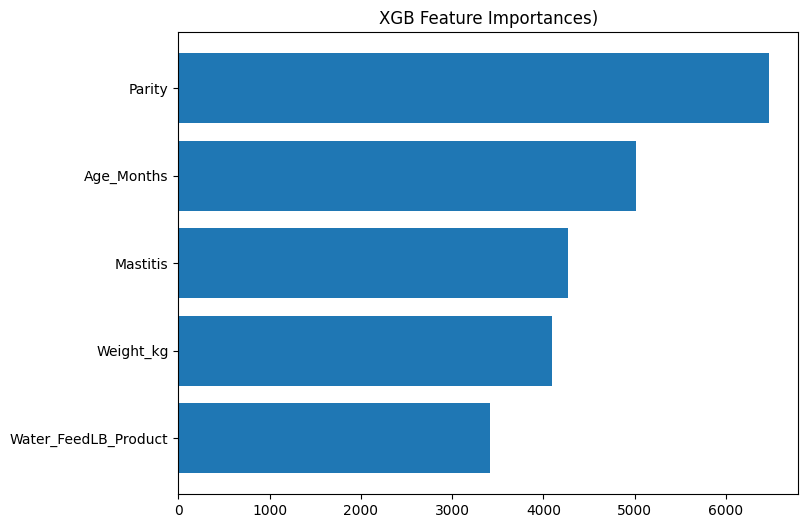

In [ ]:
'''Comparing feature importances'''

xgb_importance = (
    model_xgb.get_score(importance_type="gain")
)

xgb_imp_df = (
    pd.DataFrame.from_dict(xgb_importance, orient="index", columns=["Gain"])
    .rename_axis("Feature")
    .reset_index()
    .sort_values("Gain", ascending=False)
)

display(xgb_imp_df.head(50))

plt.figure(figsize=(8, 6))
plt.barh(xgb_imp_df.head(5)["Feature"], xgb_imp_df.head(5)["Gain"])
plt.gca().invert_yaxis()
plt.title("XGB Feature Importances)")
plt.show()

,Feature,Gain
3,Age_Months,7.235299e+06
4,Weight_kg,5.878091e+06
33,Water_FeedLB_Product,3.614405e+06
5,Parity,3.606947e+06
32,Month_Mean_Yield,2.441146e+06
30,Mastitis,1.044706e+06
6,Lactation_Stage,4.965131e+05
29,Feed_Quantity_lb,3.820429e+05
7,Days_in_Milk,3.248296e+05
23,IBR_Vaccine,3.142487e+05


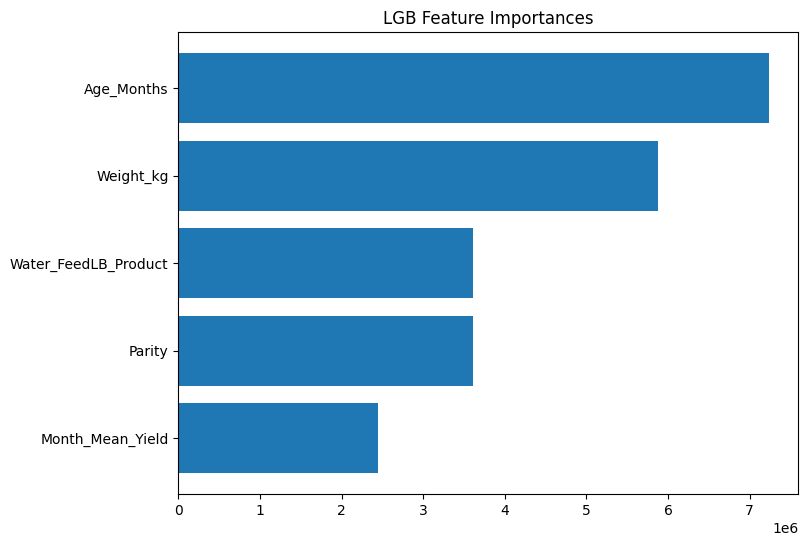

In [19]:
lgb_imp = model_lgb.feature_importance(importance_type="gain")
lgb_features = X_train.columns

lgb_imp_df = (
    pd.DataFrame({"Feature": lgb_features, "Gain": lgb_imp})
    .sort_values("Gain", ascending=False)
)

display(lgb_imp_df.head(50))

plt.figure(figsize=(8, 6))
plt.barh(lgb_imp_df.head(5)["Feature"], lgb_imp_df.head(5)["Gain"])
plt.gca().invert_yaxis()
plt.title("LGB Feature Importances")
plt.show()


,Feature,Importance
3,Age_Months,27.080516
4,Weight_kg,20.058385
33,Water_FeedLB_Product,14.752975
5,Parity,13.887768
32,Month_Mean_Yield,9.143541
30,Mastitis,4.044994
6,Lactation_Stage,1.968448
7,Days_in_Milk,1.386648
23,IBR_Vaccine,1.291256
22,Anthrax_Vaccine,1.282906


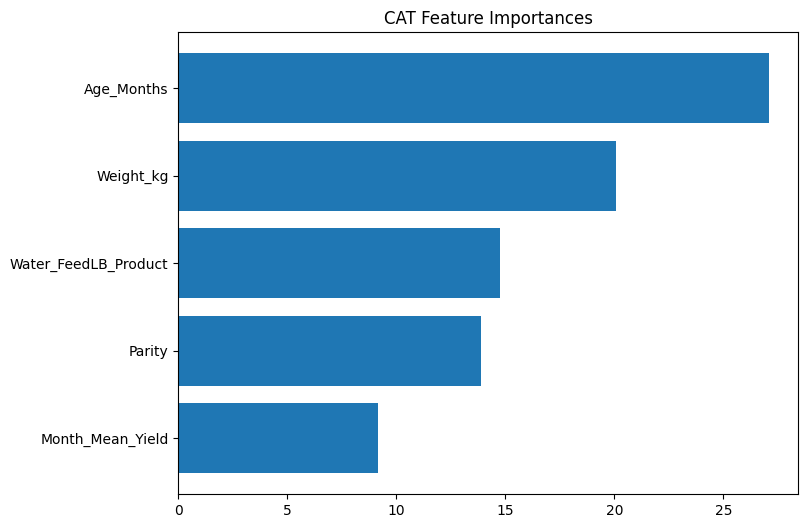

In [16]:
cat_imp = model_cat.get_feature_importance()
cat_features = X_train.columns

cat_imp_df = (
    pd.DataFrame({"Feature": cat_features, "Importance": cat_imp})
    .sort_values("Importance", ascending=False)
)

display(cat_imp_df.head(50))

plt.figure(figsize=(8, 6))
plt.barh(cat_imp_df.head(5)["Feature"], cat_imp_df.head(5)["Importance"])
plt.gca().invert_yaxis()
plt.title("CAT Feature Importances")
plt.show()


### SHAP

In [ ]:
''' Using SHAP to see which features interactions are worth experimenting with '''

train_pool = Pool(X_train, y_train, cat_features=cat_cols)

shap_values = model_cat.get_feature_importance(
    train_pool,
    type="ShapValues"
)

shap_values_no_bias = shap_values[:, :-1]
feature_names = X_train.columns.tolist()

mean_abs_shap = np.mean(np.abs(shap_values_no_bias), axis=0)

shap_df = pd.DataFrame({
    "Feature": feature_names,
    "MeanAbsSHAP": mean_abs_shap
}).sort_values("MeanAbsSHAP", ascending=False)


In [24]:
interaction = model_cat.get_feature_importance(
    train_pool,
    type="Interaction"
)

interaction_df = (
    pd.DataFrame(interaction, columns=["feat1_idx", "feat2_idx", "strength"])
      .assign(
          feat1=lambda d: d["feat1_idx"].map(lambda x: feature_names[int(x)]),
          feat2=lambda d: d["feat2_idx"].map(lambda x: feature_names[int(x)])
      )
      .sort_values("strength", ascending=False)
)

interaction_df.head(10)


,feat1_idx,feat2_idx,strength,feat1,feat2
0,4.0,33.0,4.037522,Weight_kg,Water_FeedLB_Product
1,4.0,32.0,3.585253,Weight_kg,Month_Mean_Yield
2,3.0,4.0,3.411424,Age_Months,Weight_kg
3,32.0,33.0,3.009937,Month_Mean_Yield,Water_FeedLB_Product
4,3.0,33.0,2.817128,Age_Months,Water_FeedLB_Product
5,5.0,32.0,2.319017,Parity,Month_Mean_Yield
6,4.0,5.0,2.301770,Weight_kg,Parity
7,30.0,33.0,2.176066,Mastitis,Water_FeedLB_Product
8,4.0,30.0,2.104475,Weight_kg,Mastitis
9,3.0,31.0,1.897656,Age_Months,Farm_Std_Yield


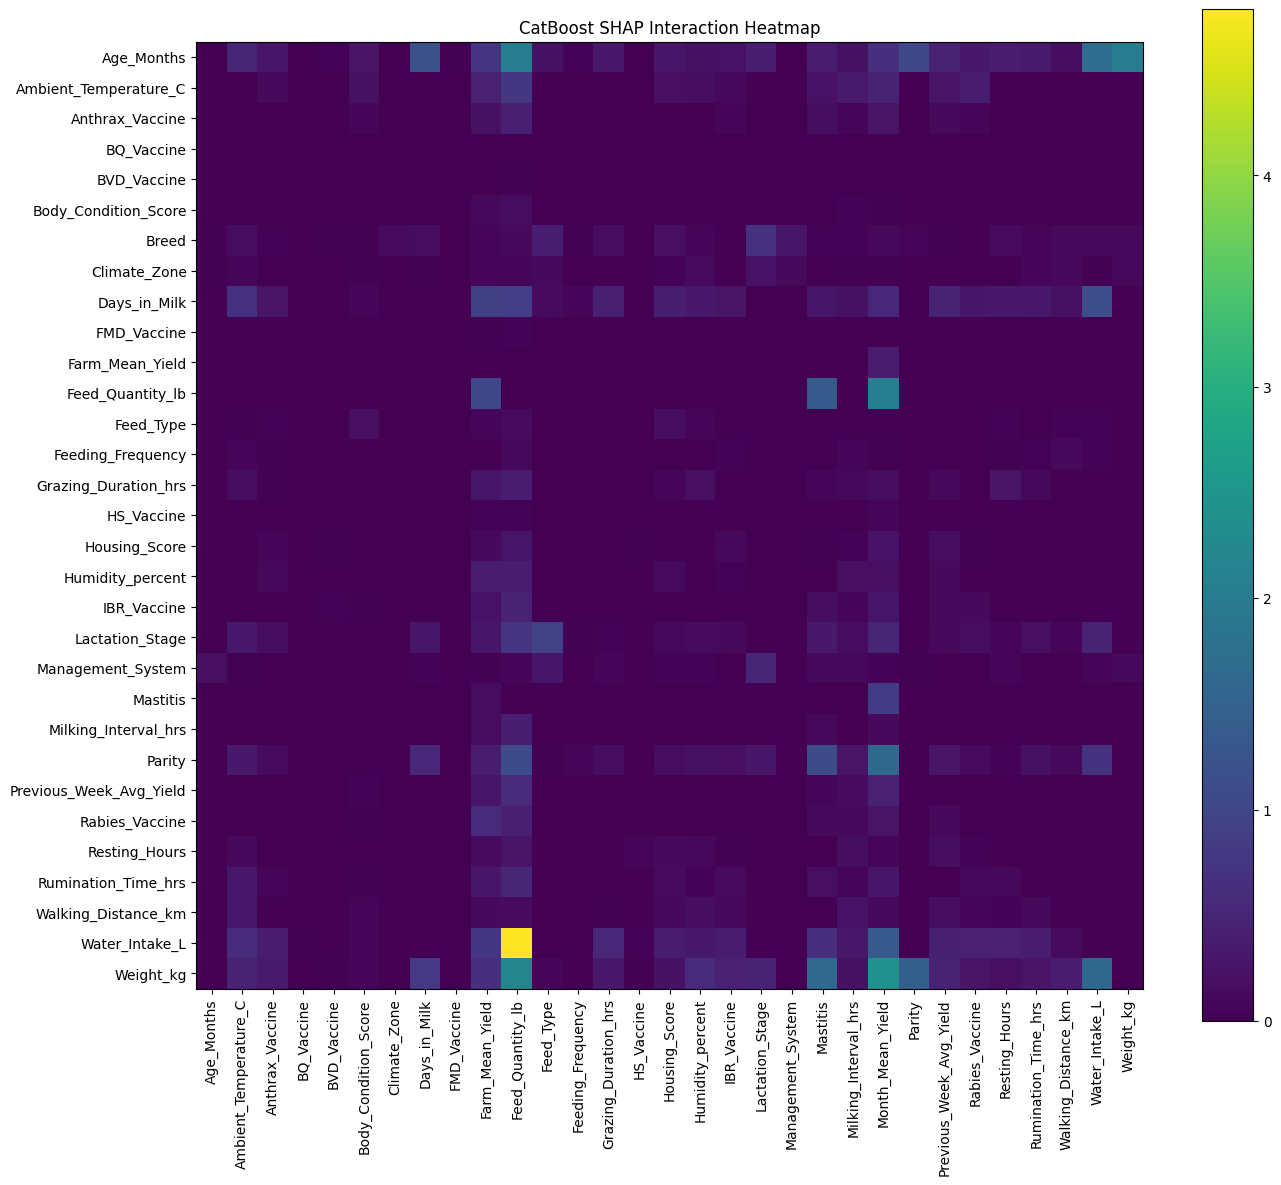

In [ ]:
pivot = interaction_df.pivot_table(
    index="feat1",
    columns="feat2",
    values="strength",
    fill_value=0
)

plt.figure(figsize=(14,12))
plt.imshow(pivot, cmap="viridis")
plt.xticks(range(len(pivot.columns)), pivot.columns, rotation=90)
plt.yticks(range(len(pivot.index)), pivot.index)
plt.colorbar()
plt.title("CatBoost SHAP Interaction Heatmap")
plt.tight_layout()
plt.show()

''' SHAP has highlighted a number of interesting feature interactions. We'll exeriment with
these in feature engineering e.g. Feed_Quantity_lb * Weight.'''